In [57]:
# random forest classifier
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# classification report

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt


# f1, precision, recall, weighted accuracy
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
    balanced_accuracy_score,
)

# xgboost classifier

from xgboost import XGBClassifier

# lightgbm classifier

from lightgbm import LGBMClassifier

# catboost classifier

from catboost import CatBoostClassifier

import pandas as pd

# Adaboot classifier
from sklearn.ensemble import AdaBoostClassifier

# SVM

from sklearn.svm import SVC

# KNN

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

In [58]:
RAW_DIR = "data/raw"
PROCESSED_DIR = "data/processed"

In [59]:
dataset = pd.read_csv(f"{RAW_DIR}/fetal_health.csv")

In [60]:
dataset.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')

In [61]:
label2class = {
    1: "Normal",
    2: "Suspect",
    3: "Pathology"
}

labeel2class_encoded = {
    0: "Normal",
    1: "Suspect",
    2: "Pathology"
}

In [62]:
# split (train, test) stratified and save into processed directory

train, test = train_test_split(
    dataset, test_size=0.5, stratify=dataset["fetal_health"], random_state=42
)

train.to_csv(f"{PROCESSED_DIR}/train.csv", index=False)

test.to_csv(f"{PROCESSED_DIR}/test.csv", index=False)

In [63]:
x_train = train.drop("fetal_health", axis=1)
y_train = train["fetal_health"]

y_train = LabelEncoder().fit_transform(y_train)

In [64]:
x_test = test.drop("fetal_health", axis=1)

y_test = test["fetal_health"]

y_test = LabelEncoder().fit_transform(y_test)

In [65]:
x_train_flipped = x_test.copy()
x_test_flipped = x_train.copy()

y_train_flipped = y_test.copy()
y_test_flipped = y_train.copy()

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [67]:
# Dropping 'severe_decelerations' from the training and testing datasets
x_train_no_severe = x_train.drop('severe_decelerations', axis=1)
x_test_no_severe = x_test.drop('severe_decelerations', axis=1)

x_train_no_severe_scaled = scaler.fit_transform(x_train_no_severe)
x_test_no_severe_scaled = scaler.transform(x_test_no_severe)

In [68]:
# Copying the datasets to keep the 'severe_decelerations' column separate
x_train_severe = x_train.copy()
x_test_severe = x_test.copy()

# Removing 'severe_decelerations' temporarily for scaling
severe_train = x_train_severe.pop('severe_decelerations')
severe_test = x_test_severe.pop('severe_decelerations')

# Scaling the remaining features
scaler_severe = StandardScaler()
x_train_severe_scaled = scaler_severe.fit_transform(x_train_severe)
x_test_severe_scaled = scaler_severe.transform(x_test_severe)

# Adding the unscaled 'severe_decelerations' back to the scaled datasets

x_train_severe_scaled = np.column_stack((x_train_severe_scaled, severe_train))

x_test_severe_scaled = np.column_stack((x_test_severe_scaled, severe_test))

In [69]:
x_train_scaled = scaler.fit_transform(x_train)

x_test_scaled = scaler.transform(x_test)

In [70]:
models = [
    ("Random Forest", RandomForestClassifier()),
    ("XGBoost", XGBClassifier()),
    ("LightGBM", LGBMClassifier(verbosity=-1)),
    ("CatBoost", CatBoostClassifier(logging_level="Silent")),
    ("AdaBoost", AdaBoostClassifier()),
    ("SVM", SVC()),
    ("KNN", KNeighborsClassifier()),
]

In [71]:
FOLDS = 10

In [72]:
# Define the models and their corresponding parameter grids
models_params = {
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 6, 9],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(logging_level="Silent"),
        "params": {
            "iterations": [100, 200, 300],
            "depth": [4, 6, 10],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0],
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"],
            "decision_function_shape": ["ovo", "ovr"]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [1, 3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "algorithm": ["auto", "ball_tree", "kd_tree"],
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(verbosity=-1),
        "params": {
            "num_leaves": [31, 62, 128],
            "max_depth": [10, 20, 30],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
}

### With Histogram

In [73]:
# remove warnings
import warnings

warnings.filterwarnings("ignore")

In [74]:
def train_models(y_train, x_train_scaled, FOLDS, models_params):
    best_estimators = {}
    for model_name, mp in models_params.items():
        print(f"Running GridSearchCV for {model_name}")
        grid_search = GridSearchCV(
            mp['model'], mp['params'], cv=FOLDS, scoring='f1_weighted', n_jobs=-1)
        grid_search.fit(x_train_scaled,
                        y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}")
    return best_estimators

In [ ]:

best_estimators_regular = train_models(
    y_train, x_train_scaled, FOLDS, models_params)

In [22]:
best_estimators_severe = train_models(
    y_train, x_train_severe_scaled, FOLDS, models_params)

Running GridSearchCV for KNN
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
Best score for KNN: 0.9068398249403241


In [23]:
best_estimators_no_severe = train_models(
    y_train, x_train_no_severe_scaled, FOLDS, models_params)

Running GridSearchCV for KNN
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
Best score for KNN: 0.9068398249403241


In [24]:
# flipped
best_estimators_regular_flipped = train_models(
    y_train_flipped, x_train_flipped, FOLDS, models_params)

Running GridSearchCV for KNN
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best score for KNN: 0.8884979003068796


In [34]:
# Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 100}
# Best score for AdaBoost: 0.946292338712755
# Running GridSearchCV for SVM
# Best parameters for SVM: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}
# Best score for SVM: 0.93621407776581
# Running GridSearchCV for KNN
# Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
# Best score for KNN: 0.9300374783007845
# Running GridSearchCV for LightGBM
# Best parameters for LightGBM: {'learning_rate': 0.3, 'max_depth': 20, 'num_leaves': 62}
# Best score for LightGBM: 0.9536882963392233
# Running GridSearchCV for Random Forest
# Best parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200}
# Best score for Random Forest: 0.9484834496142633
# Running GridSearchCV for XGBoost
# Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
# Best score for XGBoost: 0.9515821413426231
# Running GridSearchCV for CatBoost
# Best parameters for CatBoost: {'depth': 6, 'iterations': 300, 'learning_rate': 0.3}
# Best score for CatBoost: 0.9503466423071121

In [27]:
# predict test with flipped and regular

y_pred_flipped = KNeighborsClassifier(
    algorithm='auto', n_neighbors=1,  weights='uniform').fit(x_train_flipped, y_train_flipped).predict(x_test_flipped)

y_pred_regular = KNeighborsClassifier(
    algorithm='auto', n_neighbors=3,  weights='distance').fit(x_train, y_train).predict(x_test)

## Tests

In [87]:
# Running GridSearchCV for Random Forest
# Best parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
# Best score for Random Forest: 0.9333807826643821
# Running GridSearchCV for XGBoost
# Best parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 200}
# Best score for XGBoost: 0.9399151626432072
# Running GridSearchCV for CatBoost
# Best parameters for CatBoost: {'depth': 10, 'iterations': 300, 'learning_rate': 0.1}
# Best score for CatBoost: 0.9358157199913281
# Running GridSearchCV for AdaBoost
# Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 200}
# Best score for AdaBoost: 0.8978591517313683
# Running GridSearchCV for SVM
# Best parameters for SVM: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}
# Best score for SVM: 0.9040411337653472
# Running GridSearchCV for KNN
# Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
# Best score for KNN: 0.8995704320834053
# Running GridSearchCV for LightGBM
# Best parameters for LightGBM: {'learning_rate': 0.1, 'max_depth': 20, 'num_leaves': 31}
# Best score for LightGBM: 0.9458171934447821

ensemble_models = [
    ("Random Forest", RandomForestClassifier(
        max_depth=30, min_samples_split=2, n_estimators=100)),
    ("XGBoost", XGBClassifier(
        learning_rate=0.3, max_depth=9, n_estimators=200)),
    ("LightGBM", LGBMClassifier(
        learning_rate=0.1, max_depth=20, num_leaves=31, verbosity=-1)),
    ("CatBoost", CatBoostClassifier(
        depth=10, iterations=300, learning_rate=0.1)),
    ("SVM", SVC(C=10, decision_function_shape='ovo',
     gamma='scale', kernel='rbf', probability=True)),
    ("KNN", KNeighborsClassifier(
        algorithm='auto', n_neighbors=3, weights='distance')),
    ("AdaBoost", AdaBoostClassifier(
        learning_rate=0.1, n_estimators=200))
]


In [88]:
for model in ensemble_models:
    model[1].fit(x_train, y_train)
    y_pred_e = model[1].predict(x_test)

    print(f"Classification report for {model[0]}")
    print(classification_report(y_test, y_pred_e))
    print("\n")

Classification report for Random Forest
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       828
           1       0.78      0.69      0.73       147
           2       0.95      0.80      0.86        88

    accuracy                           0.92      1063
   macro avg       0.89      0.82      0.85      1063
weighted avg       0.92      0.92      0.92      1063



Classification report for XGBoost
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       828
           1       0.85      0.73      0.79       147
           2       0.96      0.89      0.92        88

    accuracy                           0.94      1063
   macro avg       0.92      0.87      0.89      1063
weighted avg       0.94      0.94      0.94      1063



Classification report for LightGBM
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       828
           1    

In [24]:
from sklearn.ensemble import VotingClassifier

In [89]:
# ensemble model

for i in range(len(ensemble_models)):
    ensemble = VotingClassifier(estimators=ensemble_models[:i+1], voting='soft')

    ensemble.fit(x_train_scaled, y_train)

    y_pred = ensemble.predict(x_test_scaled)

    print(f"Classification report for ensemble model with {i+1} models")
    print(classification_report(y_test, y_pred))
    print("\n")

Classification report for ensemble model with 1 models
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       828
           1       0.81      0.73      0.77       147
           2       0.92      0.78      0.85        88

    accuracy                           0.93      1063
   macro avg       0.89      0.83      0.86      1063
weighted avg       0.93      0.93      0.93      1063



Classification report for ensemble model with 2 models
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       828
           1       0.86      0.73      0.79       147
           2       0.96      0.90      0.93        88

    accuracy                           0.94      1063
   macro avg       0.92      0.87      0.90      1063
weighted avg       0.94      0.94      0.94      1063



Classification report for ensemble model with 3 models
              precision    recall  f1-score   support

           0  

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       828
           1       0.86      0.75      0.80       147
           2       0.96      0.90      0.93        88

    accuracy                           0.94      1063
   macro avg       0.93      0.88      0.90      1063
weighted avg       0.94      0.94      0.94      1063



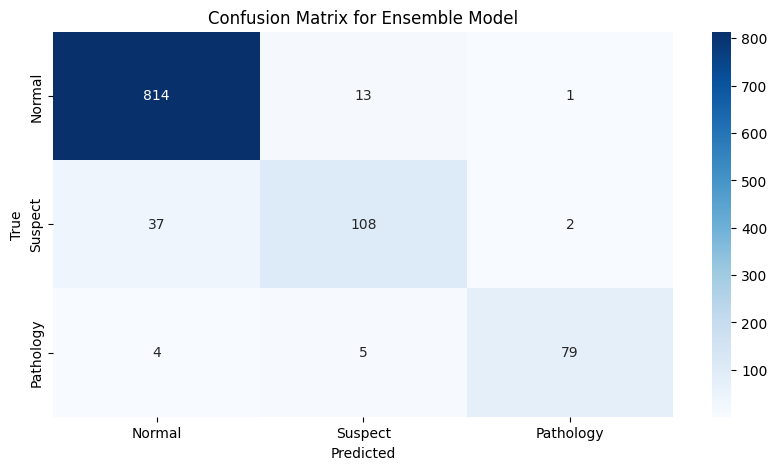

In [27]:
# matrix confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix

c = confusion_matrix(y_test, y_pred)

# plot

plt.figure(figsize=(10, 5))

sns.heatmap(c, annot=True, fmt="d", cmap="Blues",
            xticklabels=[label2class[i] for i in range(1, 4)],
            yticklabels=[label2class[i] for i in range(1, 4)])

plt.title(f"Confusion Matrix for Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")


plt.show()

In [28]:
# smote
from imblearn.over_sampling import ADASYN

In [29]:

smote = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    x_train_scaled, y_train)

In [30]:

ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_adasyn = ensemble.predict(x_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4731
[LightGBM] [Info] Number of data points in the train set: 2494, number of used features: 21
[LightGBM] [Info] Start training from score -1.103838
[LightGBM] [Info] Start training from score -1.085863
[LightGBM] [Info] Start training from score -1.106260
0:	learn: 0.9941630	total: 60.6ms	remaining: 18.1s
1:	learn: 0.9186228	total: 123ms	remaining: 18.3s
2:	learn: 0.8428533	total: 187ms	remaining: 18.5s
3:	learn: 0.7778261	total: 255ms	remaining: 18.9s
4:	learn: 0.7209948	total: 320ms	remaining: 18.9s
5:	learn: 0.6717651	total: 381ms	remaining: 18.7s
6:	learn: 0.6262912	total: 448ms	remaining: 18.8s
7:	learn: 0.5854174	total: 514ms	remaining: 18.7s
8:	learn: 0.5464586	total: 578ms	remaining: 18.7s
9:	learn: 0.5152812	total: 645ms	remaining: 18.7s
10:	learn: 0.4867014	total: 710ms	remaining: 18.6

In [31]:
print(classification_report(y_test, y_pred_adasyn))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       828
           1       0.79      0.82      0.80       147
           2       0.91      0.91      0.91        88

    accuracy                           0.94      1063
   macro avg       0.89      0.90      0.89      1063
weighted avg       0.94      0.94      0.94      1063



In [32]:
from imblearn.over_sampling import BorderlineSMOTE

In [33]:
# Apply BorderlineSMOTE

smote = BorderlineSMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    x_train_scaled, y_train)

ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_borderline_smote = ensemble.predict(x_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4746
[LightGBM] [Info] Number of data points in the train set: 2481, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	learn: 0.9818039	total: 59.4ms	remaining: 17.8s
1:	learn: 0.9015475	total: 120ms	remaining: 17.9s
2:	learn: 0.8324855	total: 183ms	remaining: 18.1s
3:	learn: 0.7668688	total: 255ms	remaining: 18.9s
4:	learn: 0.7117501	total: 325ms	remaining: 19.2s
5:	learn: 0.6592558	total: 387ms	remaining: 19s
6:	learn: 0.6186734	total: 452ms	remaining: 18.9s
7:	learn: 0.5680805	total: 526ms	remaining: 19.2s
8:	learn: 0.5295169	total: 591ms	remaining: 19.1s
9:	learn: 0.4939587	total:

In [34]:
print(classification_report(y_test, y_pred_borderline_smote))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       828
           1       0.78      0.82      0.80       147
           2       0.93      0.90      0.91        88

    accuracy                           0.94      1063
   macro avg       0.89      0.89      0.89      1063
weighted avg       0.94      0.94      0.94      1063



In [35]:
from imblearn.over_sampling import SMOTE

In [36]:

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    x_train_scaled, y_train)

ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_smote = ensemble.predict(x_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4889
[LightGBM] [Info] Number of data points in the train set: 2481, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	learn: 0.9849841	total: 61.5ms	remaining: 18.4s
1:	learn: 0.9027449	total: 126ms	remaining: 18.8s
2:	learn: 0.8224409	total: 188ms	remaining: 18.6s
3:	learn: 0.7513186	total: 250ms	remaining: 18.5s
4:	learn: 0.6877577	total: 312ms	remaining: 18.4s
5:	learn: 0.6350800	total: 375ms	remaining: 18.4s
6:	learn: 0.5900440	total: 436ms	remaining: 18.3s
7:	learn: 0.5460133	total: 498ms	remaining: 18.2s
8:	learn: 0.5067774	total: 562ms	remaining: 18.2s
9:	learn: 0.4733814	tota

In [37]:
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       828
           1       0.80      0.81      0.81       147
           2       0.93      0.92      0.93        88

    accuracy                           0.94      1063
   macro avg       0.90      0.90      0.90      1063
weighted avg       0.94      0.94      0.94      1063



In [38]:
# SMOTEENN

from imblearn.combine import SMOTEENN

In [39]:

smoteenn = SMOTEENN(random_state=42)

X_train_resampled, y_train_resampled = smoteenn.fit_resample(
    x_train_scaled, y_train)

ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_smoteenn = ensemble.predict(x_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4807
[LightGBM] [Info] Number of data points in the train set: 2312, number of used features: 21
[LightGBM] [Info] Start training from score -1.165229
[LightGBM] [Info] Start training from score -1.081459
[LightGBM] [Info] Start training from score -1.052545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	learn: 0.9733496	total: 61.3ms	remaining: 18.3s
1:	learn: 0.8846134	total: 125ms	remaining: 18.6s
2:	learn: 0.7994078	total: 189ms	remaining: 18.7s
3:	learn: 0.7244341	total: 255ms	remaining: 18.9s
4:	learn: 0.6601152	total: 318ms	remaining: 18.7s
5:	learn: 0.6040178	total: 376ms	remaining: 18.4s
6:	learn: 0.5508471	total: 441ms	remaining: 18.4s
7:	learn: 0.5057408	total: 503ms	remaining: 18.4s

In [40]:
print(classification_report(y_test, y_pred_smoteenn))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       828
           1       0.65      0.89      0.75       147
           2       0.88      0.90      0.89        88

    accuracy                           0.91      1063
   macro avg       0.84      0.90      0.86      1063
weighted avg       0.93      0.91      0.91      1063



In [41]:
# smoetomek

from imblearn.combine import SMOTETomek

In [42]:

smotetomek = SMOTETomek(random_state=42)

X_train_resampled, y_train_resampled = smotetomek.fit_resample(
    x_train_scaled, y_train)

ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_smotetomek = ensemble.predict(x_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4889
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 21
[LightGBM] [Info] Start training from score -1.097401
[LightGBM] [Info] Start training from score -1.099825
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	learn: 0.9857980	total: 64.3ms	remaining: 19.2s
1:	learn: 0.9079598	total: 128ms	remaining: 19.1s
2:	learn: 0.8209753	total: 189ms	remaining: 18.7s
3:	learn: 0.7557217	total: 254ms	remaining: 18.8s
4:	learn: 0.6958884	total: 316ms	remaining: 18.6s
5:	learn: 0.6432691	total: 378ms	remaining: 18.5s
6:	learn: 0.5931785	total: 441ms	remaining: 18.4s
7:	learn: 0.5485641	total: 503ms	remaining: 18.3s
8:	learn: 0.5079483	total: 563ms	remaining: 18.2s
9:	learn: 0.4789202	tota

In [43]:
print(classification_report(y_test, y_pred_smotetomek))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       828
           1       0.81      0.81      0.81       147
           2       0.91      0.91      0.91        88

    accuracy                           0.94      1063
   macro avg       0.90      0.90      0.90      1063
weighted avg       0.94      0.94      0.94      1063



In [44]:
smote = SMOTE(random_state=42, sampling_strategy='minority')

In [45]:

X_train_resampled, y_train_resampled = smote.fit_resample(
    x_train_scaled, y_train)

ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_smote_minority = ensemble.predict(x_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4267
[LightGBM] [Info] Number of data points in the train set: 1802, number of used features: 21
[LightGBM] [Info] Start training from score -0.778848
[LightGBM] [Info] Start training from score -2.499440
[LightGBM] [Info] Start training from score -0.778848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	learn: 0.9762696	total: 56.1ms	remaining: 16.8s
1:	learn: 0.8956126	total: 112ms	remaining: 16.7s
2:	learn: 0.8103639	total: 171ms	remaining: 16.9s
3:	learn: 0.7355808	total: 231ms	remaining: 17.1s
4:	learn: 0.6767752	total: 292ms	remaining: 17.2s
5:	learn: 0.6197106	total: 353ms	remaining: 17.3s
6:	learn: 0.5744159	tota

In [46]:
print(classification_report(y_test, y_pred_smote_minority))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       828
           1       0.89      0.73      0.80       147
           2       0.91      0.93      0.92        88

    accuracy                           0.94      1063
   macro avg       0.92      0.88      0.90      1063
weighted avg       0.94      0.94      0.94      1063



In [47]:
smote = SMOTE(random_state=42, sampling_strategy={
    0: x_test[y_test == 0].shape[0],
    1: x_test[y_test == 0].shape[0],
    2: x_test[y_test == 0].shape[0]
})

In [48]:

X_train_resampled, y_train_resampled = smote.fit_resample(
    x_train_scaled, y_train)

ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_smote_equal = ensemble.predict(x_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4829
[LightGBM] [Info] Number of data points in the train set: 2484, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	learn: 0.9856327	total: 60.6ms	remaining: 18.1s
1:	learn: 0.9037036	total: 122ms	remaining: 18.2s
2:	learn: 0.8180737	total: 184ms	remaining: 18.2s
3:	learn: 0.7496619	total: 246ms	remaining: 18.2s
4:	learn: 0.6866541	total: 307ms	remaining: 18.1s
5:	learn: 0.6345879	total: 369ms	remaining: 18.1s
6:	learn: 0.5906434	total: 434ms	remaining: 18.2s
7:	learn: 0.5497690	total: 499ms	remaining: 18.2s
8:	learn: 0.5098219	total: 565ms	remaining: 18.3s
9:	learn: 0.4804876	tota

In [49]:
print(classification_report(y_test, y_pred_smote_equal))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       828
           1       0.83      0.81      0.82       147
           2       0.91      0.91      0.91        88

    accuracy                           0.94      1063
   macro avg       0.90      0.90      0.90      1063
weighted avg       0.94      0.94      0.94      1063



In [50]:
smote_only_minority = SMOTE(random_state=42, sampling_strategy={
    0: x_test[y_test == 0].shape[0],
    1: 400,
    2: x_test[y_test == 2].shape[0]
}
)

X_train_resampled, y_train_resampled = smote_only_minority.fit_resample(
    x_train_scaled, y_train)

ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_smote_only_minority = ensemble.predict(x_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2814
[LightGBM] [Info] Number of data points in the train set: 1316, number of used features: 20
[LightGBM] [Info] Start training from score -0.463339
[LightGBM] [Info] Start training from score -1.190888
[LightGBM] [Info] Start training from score -2.705015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	learn: 0.9935323	total: 44.2ms	remaining: 13.2s
1:	learn: 0.9334396	total: 91.4ms	remaining: 13.6s
2:	learn: 0.8635014	total: 141ms	remaining: 14s
3:	learn: 0.7960620	total: 189ms	remaining: 14s
4:	learn: 0.7405275	total: 238ms	remaining: 14s
5:	learn: 0.7022408	total: 287ms	remaining: 14.1s
6:	learn: 0.6541075	total: 33

In [51]:
print(classification_report(y_test, y_pred_smote_only_minority))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       828
           1       0.82      0.80      0.81       147
           2       0.96      0.86      0.91        88

    accuracy                           0.94      1063
   macro avg       0.91      0.88      0.90      1063
weighted avg       0.94      0.94      0.94      1063



In [52]:


from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='not majority')
X_over, y_over = oversample.fit_resample(x_train_scaled, y_train)

ensemble.fit(X_over, y_over)

y_pred_random_oversample = ensemble.predict(x_test_scaled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1195
[LightGBM] [Info] Number of data points in the train set: 2481, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	learn: 0.9910680	total: 17.6ms	remaining: 5.27s
1:	learn: 0.8951146	total: 35.5ms	remaining: 5.29s
2:	learn: 0.8044879	total: 54.4ms	remaining: 5.39s
3:	learn: 0.7300780	total: 72.5ms	remaining: 5.36s
4:	learn: 0.6740530	total: 88.9ms	remaining: 5.25s
5:	learn: 0.6212695	total: 106ms	remaining: 5.22s
6:	learn: 0.5723245	total: 124ms	remaining: 5.2s
7:	learn: 0.5364153	total: 143ms	remaining: 5.23s
8:	lear

In [53]:
print(classification_report(y_test, y_pred_random_oversample))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       828
           1       0.83      0.81      0.82       147
           2       0.96      0.88      0.92        88

    accuracy                           0.95      1063
   macro avg       0.92      0.89      0.90      1063
weighted avg       0.95      0.95      0.95      1063



In [54]:
# flipped ensemble

ensemble.fit(x_train_flipped, y_train_flipped)

y_pred_flipped = ensemble.predict(x_test_flipped)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 1063, number of used features: 20
[LightGBM] [Info] Start training from score -0.249837
[LightGBM] [Info] Start training from score -1.978418
[LightGBM] [Info] Start training from score -2.491514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [55]:
print(classification_report(y_test_flipped, y_pred_flipped))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       827
           1       0.86      0.80      0.83       148
           2       0.91      0.92      0.92        88

    accuracy                           0.95      1063
   macro avg       0.91      0.90      0.90      1063
weighted avg       0.94      0.95      0.94      1063



In [56]:
print("Regular")
print(classification_report(y_test, y_pred))
print("ADASYN")
print(classification_report(y_test, y_pred_adasyn))
print("Borderline SMOTE")
print(classification_report(y_test, y_pred_borderline_smote))
print("SMOTE")
print(classification_report(y_test, y_pred_smote))
print("SMOTEENN")
print(classification_report(y_test, y_pred_smoteenn))
print("SMOTETomek")
print(classification_report(y_test, y_pred_smotetomek))
print("SMOTE Minority")
print(classification_report(y_test, y_pred_smote_minority))
print("SMOTE Equal")
print(classification_report(y_test, y_pred_smote_equal))
print("SMOTE Only Minority")
print(classification_report(y_test, y_pred_smote_only_minority))
print("Random Oversample")
print(classification_report(y_test, y_pred_random_oversample))


Regular
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       828
           1       0.86      0.73      0.79       147
           2       0.96      0.90      0.93        88

    accuracy                           0.94      1063
   macro avg       0.92      0.87      0.90      1063
weighted avg       0.94      0.94      0.94      1063

ADASYN
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       828
           1       0.79      0.82      0.80       147
           2       0.91      0.91      0.91        88

    accuracy                           0.94      1063
   macro avg       0.89      0.90      0.89      1063
weighted avg       0.94      0.94      0.94      1063

Borderline SMOTE
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       828
           1       0.78      0.82      0.80       147
           2       0.93      0.90      0.91

In [23]:
# Classification Report for Combined Ensemble:
#               precision    recall  f1-score   support

#          1.0       0.96      0.96      0.96       829
#          2.0       0.82      0.83      0.82       155
#          3.0       0.89      0.92      0.91        79

#     accuracy                           0.94      1063
#    macro avg       0.89      0.90      0.90      1063
# weighted avg       0.94      0.94      0.94      1063